In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집

In [3]:
# train, test 데이터 로드
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

1. train.csv / test.csv : 타이타닉 탑승자들 중 일부의 인적 정보와 생존 여부 데이터  
PassengerID : 탑승객 고유 아이디
Survival : 탑승객 생존 유무 (0: 사망, 1: 생존)  
Pclass : 등실의 등급  
Name : 이름  
Sex : 성별  
Age : 나이  
Sibsp : 함께 탐승한 형제자매, 아내, 남편의 수  
Parch : 함께 탐승한 부모, 자식의 수  
Ticket :티켓 번호  
Fare : 티켓의 요금  
Cabin : 객실번호  
Embarked : 배에 탑승한 항구 이름 ( C = Cherbourn, Q = Queenstown, S = Southampton)


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_df.shape

(891, 12)

In [8]:
test_df.shape

(418, 11)

In [9]:
train_df.isnull().sum()
#train_df.info()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_df.isnull().sum()
#test_df.info()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#2. 데이터 전처리


1. Age : 호칭에 따른 평균값
2. Cabin : 최빈값
3. Embarked : 최빈값


In [11]:
# 'Mr', 'Miss', 'Mrs', 'Ms', 'Master', 'Dr', Child로 이름 분류 후, 각 그룹의 평균값으로 결측치 채우기 (train 데이터)
age_dict_train = {}

# Mr, Ms, Miss, Mrs로 이름 분류
for title in ['Mr', 'Miss', 'Mrs', 'Ms']:
    # 해당 타이틀을 가진 사람들의 나이 평균값 계산
    age = train_df[train_df['Name'].str.contains(title)]['Age'].mean()
    # 딕셔너리에 저장
    age_dict_train[title] = int(round(age))

# 타이틀에 해당되지 않는 사람들은 Child로 분류
age_dict_train['Child'] = int(round(train_df[train_df['Name'].apply(lambda x: 'Mr' not in x and
                                                          'Miss' not in x and
                                                          'Mrs' not in x and
                                                          'Ms' not in x)]['Age'].mean()))

In [12]:
age_dict_train

{'Mr': 33, 'Miss': 22, 'Mrs': 36, 'Ms': 28, 'Child': 19}

In [13]:
# 'Mr', 'Miss', 'Mrs', 'Ms', 'Master', 'Dr', Child로 이름 분류 후, 각 그룹의 평균값으로 결측치 채우기 (test 데이터)
age_dict_test = {}

# MR, MS, MISS, MRS로 이름 분류
for title in ['Mr', 'Miss', 'Mrs']:
    # 해당 타이틀을 가진 사람들의 나이 평균값 계산
    age = test_df[test_df['Name'].str.contains(title)]['Age'].mean()
    # 딕셔너리에 저장
    age_dict_test[title] = int(round(age))

# test데이터의 Ms가 1명이므로 train데이터의 결과값을 가져와서 대체
test_df.loc[test_df['Name'].str.contains('Ms'), 'Age'] = age_dict_train['Ms']

# 타이틀에 해당되지 않는 사람들은 Child로 분류
age_dict_test['Child'] = int(round(test_df[test_df['Name'].apply(lambda x: 'Mr' not in x and
                                                       'Miss' not in x and
                                                       'Mrs' not in x and
                                                       'Ms' not in x)]['Age'].mean()))

In [14]:
age_dict_test

{'Mr': 34, 'Miss': 22, 'Mrs': 39, 'Child': 17}

In [15]:
for title, age in age_dict_train.items():
    # 위에 해당 타이틀을 가진 결측치 index 추출
    idx = train_df[train_df['Name'].str.contains(title) & train_df['Age'].isnull()].index

    # 해당 index의 결측치를 해당 타이틀의 나이 평균값으로 채우기
    train_df.loc[idx, 'Age'] = age

In [16]:
for title, age in age_dict_test.items():
    # 위에 해당 타이틀을 가진 결측치 index 추출
    idx = test_df[test_df['Name'].str.contains(title) & test_df['Age'].isnull()].index

    # 해당 index의 결측치를 해당 타이틀의 나이 평균값으로 채우기
    test_df.loc[idx, 'Age'] = age

In [17]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
# Cabin과 Embarked는 최빈값으로 채우기
train_df.fillna(train_df['Cabin'].mode()[0], inplace=True)
train_df.fillna(train_df['Embarked'].mode()[0], inplace=True)

In [19]:
# Fare은 평균값, Cabin은 최빈값으로 채우기
test_df.fillna(test_df['Fare'].mean(), inplace=True)
test_df.fillna(test_df['Cabin'].mode()[0], inplace=True)

In [20]:
# Sibsp : 함께 탐승한 형제자매, 아내, 남편의 수
# Parch : 함께 탐승한 부모, 자식의 수
# 함께 탑승한 사람의 수를 Family로 묶음
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
test_df['Family'] = test_df['SibSp'] + test_df['Parch']

In [21]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,0


In [22]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Family         0
dtype: int64

In [23]:
test_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Family         0
dtype: int64

#3. 데이터 시각화

In [24]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [25]:
# from IPython.display import Image
# Image("./titanic.jpg")

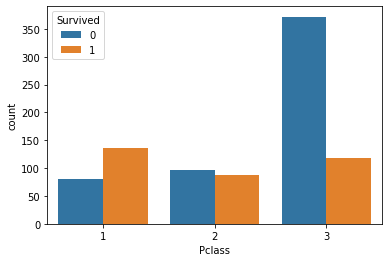

In [26]:
# 클래스별 생존, 사망자 수
sns.countplot(data = train_df, x = 'Pclass', hue='Survived');

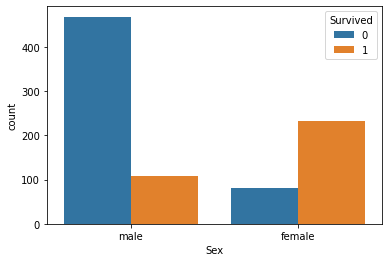

In [27]:
# 성별에 따른 생존, 사망자 수
sns.countplot(data = train_df, x = 'Sex', hue = 'Survived');

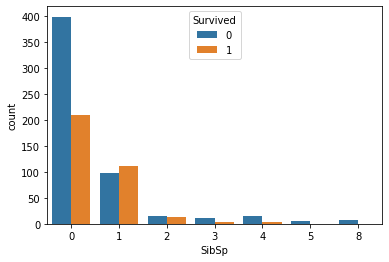

In [29]:
# 함께 탐승한 형제자매, 아내, 남편의 수에 따른 생존, 사망자 수
sns.countplot(data = train_df, x = 'SibSp', hue = 'Survived');

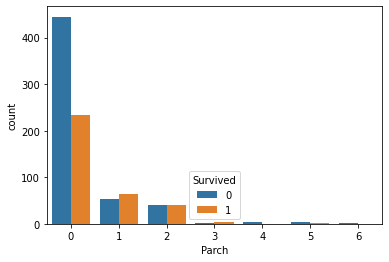

In [30]:
#함께 탐승한 부모, 자식의 수에 따른 생존, 사망자 수
sns.countplot(data = train_df, x = 'Parch', hue='Survived');

# 5. 인코딩

In [32]:
# 인코딩 전 불필요한 정보 제거
train_df.drop(['Name','PassengerId', 'Ticket','Fare','Cabin','Embarked'], axis = 1, inplace = True)
test_df.drop(['Name', 'Ticket','Fare','Cabin','Embarked'], axis = 1, inplace = True)

In [33]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Family
0,0,3,male,22.0,1,0,1
1,1,1,female,38.0,1,0,1
2,1,3,female,26.0,0,0,0
3,1,1,female,35.0,1,0,1
4,0,3,male,35.0,0,0,0
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,0
887,1,1,female,19.0,0,0,0
888,0,3,female,22.0,1,2,3
889,1,1,male,26.0,0,0,0


In [34]:
train_test_data = [train_df, test_df]

In [35]:
sex_mapping = {'male':0, 'female':1}

for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [36]:
# 머신러닝은 숫자 치이가 큰 것에 중요도를 높게 보기에 소수점사용
family_mapping ={0: 0, 1: 0.4, 2: 0.8, 3: 1.2, 4: 1.6, 5: 2.0, 6: 2.4, 7: 2.8, 8: 3.2, 9: 3.6, 10: 4}

for dataset in train_test_data:
    dataset['Family'] = dataset['Family'].map(family_mapping)

In [37]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Family
0,0,3,0,22.0,1,0,0.4
1,1,1,1,38.0,1,0,0.4
2,1,3,1,26.0,0,0,0.0
3,1,1,1,35.0,1,0,0.4
4,0,3,0,35.0,0,0,0.0
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,0.0
887,1,1,1,19.0,0,0,0.0
888,0,3,1,22.0,1,2,1.2
889,1,1,0,26.0,0,0,0.0


In [38]:
train_df.drop(['SibSp','Parch'], axis = 1, inplace = True)
test_df.drop(['SibSp','Parch'], axis = 1, inplace = True)

In [39]:
train_data = train_df.drop('Survived', axis = 1)
target = train_df['Survived']

In [40]:
train_data.head(10)

,Pclass,Sex,Age,Family
0,3,0,22.0,0.4
1,1,1,38.0,0.4
2,3,1,26.0,0.0
3,1,1,35.0,0.4
4,3,0,35.0,0.0
5,3,0,33.0,0.0
6,1,0,54.0,0.0
7,3,0,2.0,1.6
8,3,1,27.0,0.8
9,2,1,14.0,0.4


#5. 모델 선택

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle = True, random_state = 0)

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    object 
 4   Family    891 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 34.9+ KB


#6. 모델 학습

In [46]:
Classifier = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(Classifier, train_data, target, cv=k_fold, n_jobs = 1, scoring=scoring)
print(score)

ValueError: ignored

In [ ]:
np.mean(score)

In [ ]:
Classifier = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(Classifier, train_data, target, cv=k_fold, n_jobs = 1, scoring=scoring)
print(score)

In [ ]:
np.mean(score)

In [ ]:
Classifier = RandomForestClassifier(n_estimators= 9)
scoring = 'accuracy'
score = cross_val_score(Classifier, train_data, target, cv=k_fold, n_jobs = 1, scoring=scoring)
print(score)

In [ ]:
np.mean(score)

In [ ]:
Classifier = SVC()
scoring = 'accuracy'
score = cross_val_score(Classifier, train_data, target, cv=k_fold, n_jobs = 1, scoring=scoring)
print(score)

In [ ]:
np.mean(score)

#7. 모델 평가

In [ ]:
Classifier = RandomForestClassifier(n_estimators= 9)
Classifier.fit(train_data, target)

test_data = test_df.drop('PassengerId', axis = 1).copy()
prediction = Classifier.predict(test_data)

In [ ]:
submission = pd.DataFrame({
    'PassengerId' : test_df['PassengerId'],
    'Survived' : prediction
})

submission.to_csv('submission.csv', index = False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()